In [1]:
#style: make functions! even classes if necessary! funcs for FF reduction for example, etc. to reuse for labs 2 and 3!
#say what functions and key(most) lines/line groups do!
#long descriptions can be in the form of comments if about a specific block
#make graph labels BIG!
#move files to the local jupyter directory, avoiding reference to my name or group

## Data Analysis

(intro description)

In [13]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output 
import os

In [127]:
#Initial Functions

#Adapting Trevor's Function to Automatically Shape Array
def fits_data_to_3d_array(file_list): 
    for i, file in enumerate(file_list):
        with fits.open(file) as hdu:
            if i==0:  #If first iteration, create array with correct shape of data
                final_array = np.zeros((len(file_list), *hdu[0].data.shape))
            final_array[i,:,:] = hdu[0].data
    return final_array

#takes in a 3d array from the above function, median combines.
def median_combine(frame_array_3d):
    master_frame = np.median(frame_array_3d,axis=0) #takes median along the 'file_index' axis
    return master_frame

def mean_combine(frame_array_3d):
    master_frame = np.mean(frame_array_3d,axis=0) #takes median along the 'file_index' axis
    return master_frame
    
#Takes in a 2d array, saves as a fits file for viewing in ds9
def save_array_as_fits(array, new_file_name):
    hdu = fits.PrimaryHDU(data = array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(new_file_name)

# New File List Function
def create_file_list(data_directory, file_name, frame_type, num_of_files, show_list = False):
    
    '''
    This creates a list of all FITS files that will be used.
    
    Parameters:
    data_directory : path to data folder
    file_name : name of file containing data (ex.: spectrograph_flats_20s_)
                Remove anything that comes after the number!
    frame_type : type of frame saved (ex.: .FLAT, .DARK, .BIAS)
    num_of_files : number of files (must be below 11)
    '''
    
    file_list = [os.path.join(data_directory, file_name + f'.0000000{i}' + frame_type + '.FIT') for i in range(num_of_files)]

    
    if show_list: 
        for file in file_list: print(file)
    
    return file_list

def create_file_list_2(folder_path):
    files = [f for f in os.listdir(folder_path) if f.startswith('dark_frame_') and f.endswith('.DARK.FIT')]
    file_list = [os.path.join(folder_path, f) for f in files]
    exposure_times = [float(f.split('_')[2].replace('s', '')) for f in files]
    return file_list, exposure_times

#My function to cut images array   -- adapt to 3d 
def cut_images_array(image_array, y_pixel_min, y_pixel_max):
    lower_index = (-1) + y_pixel_min
    upper_index = (-1) + y_pixel_max
    image_array_cut = image_array[lower_index:upper_index,:]
    print(image_array_cut.shape)
    return image_array_cut

#My function to display image
def display_2d_array(image_array, lower_percentile=1, upper_percentile=99):
    minimum = np.percentile(image_array,lower_percentile)
    maximum = np.percentile(image_array,upper_percentile)
    plt.imshow(image_array, cmap='gray', origin = 'lower', vmin=minimum, vmax=maximum)
    plt.colorbar(location='top')

### 4.1: Bias Frames

(a description of what I do in 4.1.1 and 4.1.2)

In [15]:
#Functions and Files used in 4.1

#A normal distribution, scaled by a constant factor to fit a gaussian distribution to a non-normalized function.
def scaled_normal_dist(x, a, mean, stdev):
    return a * np.exp(-(x-mean)**2/(2.0*stdev**2)) / np.sqrt(2.0*np.pi*stdev**2)

#returns a 1d list without entries outside the bounds
def cut_1d_list(list_to_cut,bounds): 
    cut_list = []
    for x in list_to_cut:
        if bias_cut_range[0] < x < bias_cut_range[1]:
            cut_list.append(x)
    return cut_list



#The three 0C bias fits files
bias_files = ["Group 2 Data/Photometry/bias_frames_at_different_temperatures/bias_frame_at_0C_.00000010.BIAS.FIT",
              "Group 2 Data/Photometry/bias_frames_at_different_temperatures/bias_frame_at_0C_.00000011.BIAS.FIT",
              "Group 2 Data/Photometry/bias_frames_at_different_temperatures/bias_frame_at_0C_.00000012.BIAS.FIT"]

(800.0, 1200.0)

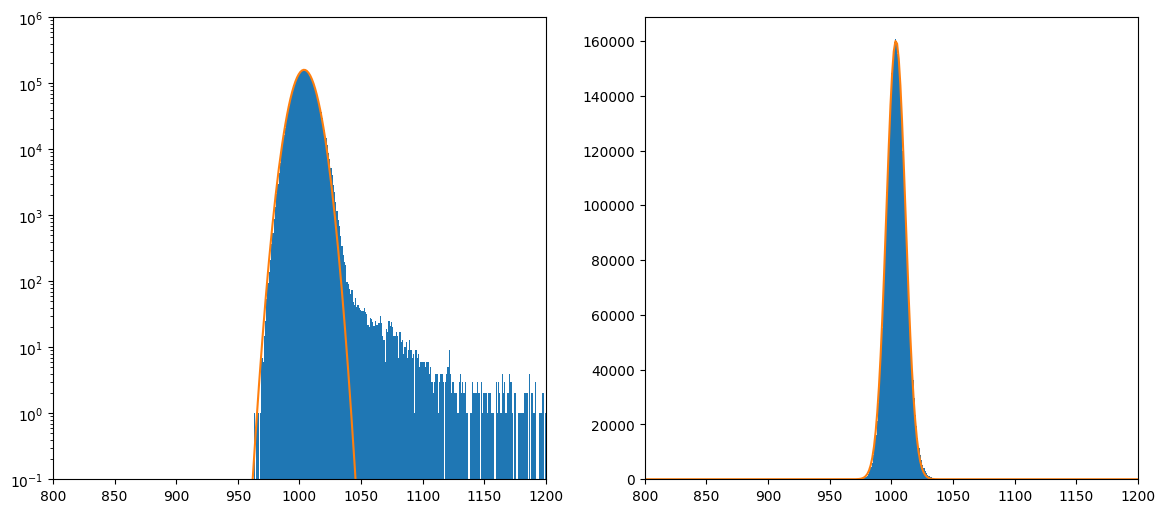

In [43]:
#Create and graph the bias histogram + fit

bias_cut_range = [500,1500] #defines what count range the fit to the histogram is based on
display_range = [800,1200] #defines the count range to show on the main graphs
cut_bias_counts_list = cut_1d_list(fits_data_to_3d_array(bias_files).flatten(),bias_cut_range)
n_bins = 1000 #number of histogram bins to create in the cut range

cut_bias_hist = np.histogram(np.array(cut_bias_counts_list),n_bins,bias_cut_range) #histogram of the cut list
bias_popt, bias_pcov = curve_fit(scaled_normal_dist,xdata=cut_bias_hist[1][:-1]+.5*(cut_bias_hist[1][1]-cut_bias_hist[1][0]),
                                 ydata=cut_bias_hist[0],p0=[20,1000,20]) #create the gaussian fit to the histogram

fig, ax = plt.subplots(ncols=2,figsize=(14,6))
ax[0].hist(fits_data_to_3d_array(bias_files).flatten(),n_bins,bias_cut_range)
ax[1].hist(fits_data_to_3d_array(bias_files).flatten(),n_bins,bias_cut_range)
xs = np.linspace(display_range[0],display_range[1],300)
ax[0].plot(xs,scaled_normal_dist(xs, *bias_popt))
ax[0].set_ylim(.1,1e6)
ax[0].set_yscale('log')
ax[1].plot(xs,scaled_normal_dist(xs, *bias_popt))
ax[1].set_xlim(display_range[0],display_range[1])
ax[0].set_xlim(display_range[0],display_range[1])

In [50]:
#Identify hot pixels as those not used in fit, which can be found by varying the graphs above:
counts_list_length = len(fits_data_to_3d_array(bias_files).flatten())
n_hot_pixels = counts_list_length-len(cut_bias_counts_list)

print(f"There are {n_hot_pixels} total identified hot pixels across 3 files, a fraction of {n_hot_pixels/counts_list_length:.7f} of the total.")

There are 26 total identified hot pixels across 3 files, a fraction of 0.0000083 of the total.


In [51]:
#This block prints the headers of one of the bias fits files.
#According to the CCD datasheet, gain = 2., readout noise 14.8e- RMS. Gain agrees to within 3% with header
with fits.open("Group 2 Data/Photometry/bias_frames_at_different_temperatures/bias_frame_at_0C_.00000010.BIAS.FIT") as hdu:
            print(hdu[0].header)

print('\n', f"The readout noise from our data is {2.06*7.80:.1f} e-, which is {100.*(2.06*7.80-14.8)/(14.8):.2f}% away from the datasheet value.")

SIMPLE  =                    T/CCDSOFT-SOFTWARE BISQUE 3                        BITPIX  =                   16                                                  NAXIS   =                    2                                                  NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  BSCALE  = +1.000000000000E+000                                                  BZERO   = +3.276800000000E+004                                                  BIAS    =                  100                                                  FOCALLEN= +0.000000000000E+000                                                  APTAREA = +0.000000000000E+000                                                  APTDIA  = +0.000000000000E+000                                                  DATE-OBS= '2024-08-30T01:57:32.328'                                             TIME-OBS= '01:57:32.328        '        

### 4.2.1 (Anthony)

In [85]:
#creates the list of FITS files for the .3s dark frames
dark_file_list = create_file_list(data_directory = 'Group 2 Data\Photometry\dark_frames_at_.3s_exposure', 
                 file_name = 'dark_0.3s_exposure_', 
                 frame_type = '.DARK', 
                 num_of_files = 10,
                 show_list=True)

Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000000.DARK.FIT
Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000001.DARK.FIT
Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000002.DARK.FIT
Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000003.DARK.FIT
Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000004.DARK.FIT
Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000005.DARK.FIT
Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000006.DARK.FIT
Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000007.DARK.FIT
Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000008.DARK.FIT
Group 2 Data\Photometry\dark_frames_at_.3s_exposure\dark_0.3s_exposure_.00000009.DARK.FIT


In [86]:
#4.2.1 functions

#this is no longer used
def hot_pixel_identifier(pixel_counts_array):
    arr_shape = np.shape(pixel_counts_array)
    hot_pixel_array = np.zeros((int(arr_shape[0]), int(arr_shape[1])))
    for (i,j), value in np.ndenumerate(pixel_counts_array):
        if value >= 2000: hot_pixel_array[i,j] = 1         #THRESHOLD!!
    print(np.shape(hot_pixel_array))
    return hot_pixel_array

def hot_pixel_array_sum_rows(hot_pixel_array):
    raw_data_shape = shape_of_raw_data(file_list)
    hot_pixels_1d = np.zeros(len(hot_pixel_array))    
    for row in range(hot_pixel_array.shape[0]): 
        hot_pixels_1d[row] = np.sum(hot_pixel_array[row])
        if hot_pixels_1d[row] > 0: 
            print('Hot pixel in row ', row)
            print('Location:', np.unravel_index(row, raw_data_shape))
    return hot_pixels_1d

def shape_of_raw_data(file_list):  
    for file in file_list:
        with fits.open(file) as hdu:
            data = hdu[0].data
            return(np.shape(data))

In [90]:
#Performs a median combine to get a master dark frame:
dark_array_3d = fits_data_to_3d_array(dark_file_list)
master_dark_frame = median_combine(dark_array_3d)

In [59]:
#Save as fits to view on ds9
save_array_as_fits(master_dark_frame, "master_dark_frame.FITS")

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 6.00000e+00,
        1.30000e+01, 6.20000e+01, 1.36000e+02, 4.24000e+02, 1.06400e+03,
        2.73800e+03, 6.32600e+03, 1.38390e+04, 2.90900e+04, 5.50630e+04,
        1.00816e+05, 1.67773e+05, 2.66642e+05, 3.86529e+05, 5.33911e+05,
        6.81314e+05, 8.24419e+05, 9.31490e+05, 9.92465e+05, 9.92742e+05,
        9.40628e+05, 8.43573e+05, 7.14405e+05, 5.78967e+05, 4.42266e+05,
        3.28769e+05, 2.28194e+05, 1.57076e+05, 1.00758e+05, 6.46390e+04,
        3.88490e+04, 2.34090e+04, 1.31270e+04, 7.64800e+03, 5.65100e+03]),
 array([ 960.,  962.,  964.,  966.,  968.,  970.,  972.,  974.,  976.,
         978.,  980.,  982.,  984.,  986.,  988.,  990.,  992.,  994.,
         996.,  998., 1000., 1002., 1004., 1006., 1008., 1010., 1012.,
        1014., 1016., 1018., 1020., 1022., 1024., 1026., 1028., 1030.,
        1032., 1034., 1036., 1038., 1040.]),
 <BarContainer object of 40 artists>)

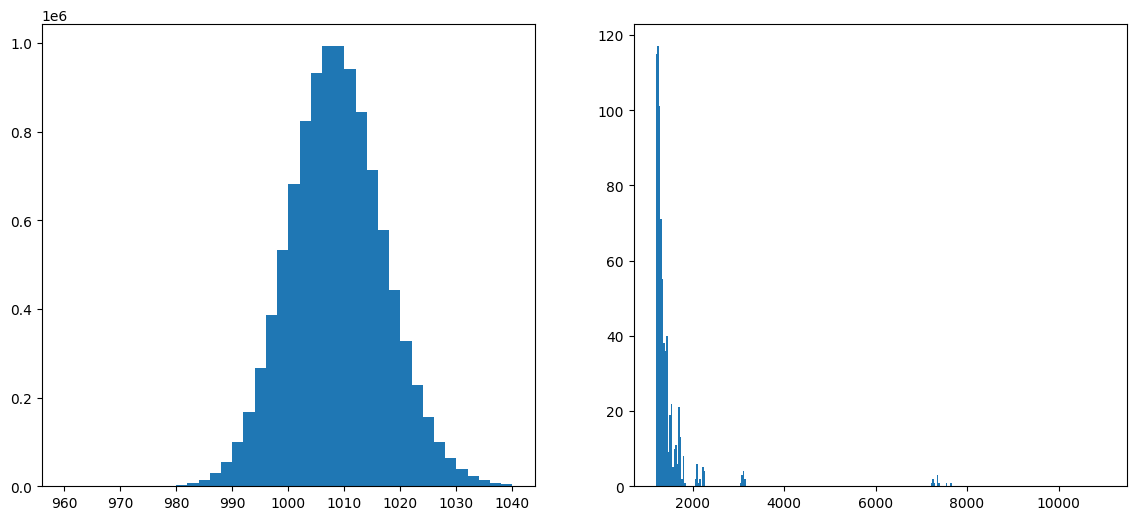

In [92]:
                                   #Identifying Hot Pixels

#plot a main histogram and a secondary histogram to see hot pixels
fig, ax = plt.subplots(ncols=2,figsize=(14,6))
ax[1].hist(flattened_dark_array,300,[1200,11000])
ax[0].hist(flattened_dark_array,40,[960,1040])

In [99]:
                                   #Identifying Hot Pixels Cont...
#Threshold used: 2000 counts

#The following creates an array (with the same shape as the input) filled with zeros except for the
#pixels that are above the threshhold - they are given a value equal to 1.
hot_pixel_array = np.where(dark_array_3d > 2000,
                           np.ones((len(dark_array_3d[0,:,0]),len(dark_array_3d[0,0,:]))),
                           np.zeros((len(dark_array_3d[0,:,0]),len(dark_array_3d[0,0,:]))))
#np.savetxt("hot_pixel_array.csv", hot_pixel_array, delimiter=",", fmt='%d') #For manual viewing
print('Number of hot pixels across all dark frames: ', np.sum(hot_pixel_array))

#sums the 3d hot pixel array over the file index
#The purpose of this is to see if the identified hot pixels are "hot" for all images. 
hot_pixel_rows_summed = np.sum(hot_pixel_array, axis=0)
print('Number of hot pixels: ', np.sum(hot_pixel_rows_summed)) #Double check sum
#np.savetxt("hot_pixel_rows_summed.csv", hot_pixel_rows_summed, delimiter=",", fmt='%d')

Number of hot pixels across all dark frames:  50.0
Number of hot pixels:  50.0


In [100]:
#Gauge Middle Value for Counts, and other statistics
median = np.median(dark_array_3d)
mean = dark_array_3d.mean()
minimum = np.min(dark_array_3d)
maximum = np.max(dark_array_3d)
print('median: ', median, 'mean: ', mean, 'min: ', minimum, 'max: ', maximum)
max_index = np.argmax(dark_array_3d)
print(max_index)

median:  1008.0 mean:  1008.3034660339356 min:  967.0 max:  18372.0
1046559


## 4.2.2 (Ronan)

In [102]:
# Define folder path and file naming pattern
folder_path = r"Group 2 Data\Photometry\dark_frames_at_different_exposure_times"
# Paths to bias frames
bias_frame_paths = [
    r"Group 2 Data\Photometry\bias_frames_at_different_temperatures\bias_frame_at_0C_.00000010.BIAS.FIT",
    r"Group 2 Data\Photometry\bias_frames_at_different_temperatures\bias_frame_at_0C_.00000011.BIAS.FIT",
    r"Group 2 Data\Photometry\bias_frames_at_different_temperatures\bias_frame_at_0C_.00000012.BIAS.FIT"
]

Generates a list of filenames in the directory that match the pattern dark_frame_*.DARK.FIT, creates a path, and extracts the exposure times as floats for calculations, and returns file paths and exp times.

In [103]:
#pixel data/conversion
def load_dark_frames(file_list):
    pixel_counts_list = []
    for file in file_list:
        if os.path.isfile(file):
            try:
                with fits.open(file) as hdu:
                    pixel_counts_list.append(hdu[0].data.flatten())
            except Exception as e:
                print(f"Error loading file {file}: {e}")
        else:
            print(f"File not found: {file}")
    return np.array(pixel_counts_list)

Stores pixel data for each dark frame and flattens it into a 1D array and returns them as a Numpy array

In [104]:
# calculates mean count, stdv, and uncertainty
def calculate_statistics(frames):
    means = np.mean(frames, axis=1)
    std_devs = np.std(frames, axis=1)
    uncertainties = std_devs / np.sqrt(frames.shape[1])
    return means, uncertainties

function calculates mean count values of frames per pixel and the associated standard deviation. As well as the uncertainty (statistical) using the stdv and #of frames.

In [105]:
#linear regression calculations
def linear_fit(x, slope, intercept):
    return slope * x + intercept

def perform_linear_regression(x, y, yerr):
    popt, pcov = curve_fit(linear_fit, x, y, sigma=yerr, absolute_sigma=True)
    return popt, np.sqrt(np.diag(pcov))

linear fit defines a function for "fitting" with parameters of x, slope, and intercept. perform_linear_regrssion fits the function to our data using exposure times (x) , mean count (y) , and uncertainties (yerr). Returns optimized parameters and standard error

In [108]:
#plotting 
def plot_mean_vs_exposure(exposure_times, means, uncertainties, slope, intercept):
    plt.errorbar(exposure_times, means, yerr=uncertainties, fmt='o', label='Data')
    plt.plot(exposure_times, linear_fit(np.array(exposure_times), slope, intercept), 'r-', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
    plt.xlabel('Exposure Time (s)')
    plt.ylabel('Mean Counts')
    plt.legend()
    plt.show()

def plot_residuals(exposure_times, means, uncertainties, slope, intercept):
    fit_line = linear_fit(np.array(exposure_times), slope, intercept)
    residuals = np.array(means) - fit_line
    plt.errorbar(exposure_times, residuals, yerr=uncertainties, fmt='o', label='Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Exposure Time (s)')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

This cell block contains the plotting of both the relationship between mean counts vs. exposure times as well the residuals (with uncertainties) of data points.

In [109]:
# Function to calculate the mean of bias frames
def calculate_bias_mean(bias_paths):
    bias_means = []
    for path in bias_paths:
        try:
            with fits.open(path) as hdul:
                data = hdul[0].data
                bias_means.append(np.mean(data))
        except Exception as e:
            print(f"Error reading bias frame {path}: {e}")
    # Calculate the overall mean of the bias frames
    overall_bias_mean = np.mean(bias_means)
    print(f"Calculated mean of the bias frames: {overall_bias_mean:.2f}")
    return overall_bias_mean

Cell block calculates the means of the bias frames for subtraction to the dark frames in calculating dark current estimation.

In [110]:
#dark current estimation
def estimate_dark_current(means, exposure_times, gain):
    dark_current = np.mean((np.array(means)-calculate_bias_mean(bias_frame_paths)) / np.array(exposure_times))*gain
    print("averaged dark frame mean", np.array(means)) 
    dark_current_std = np.std((np.array(means)-calculate_bias_mean(bias_frame_paths)) / np.array(exposure_times))
    return dark_current, dark_current_std

calculates average resulting dark current using average of the quotient between mean counts and exposure times.

[1089.87830639 1008.69760799 1106.98442459 1020.00199699 1029.44412804
 1038.41212845 1047.05791283 1056.19071388 1072.58418083] [0.37765927 0.09366332 0.42681165 0.12440165 0.15981561 0.1910704
 0.22605351 0.25996518 0.32007864]


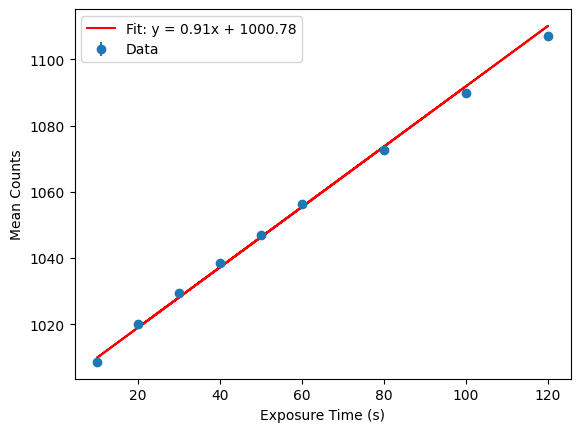

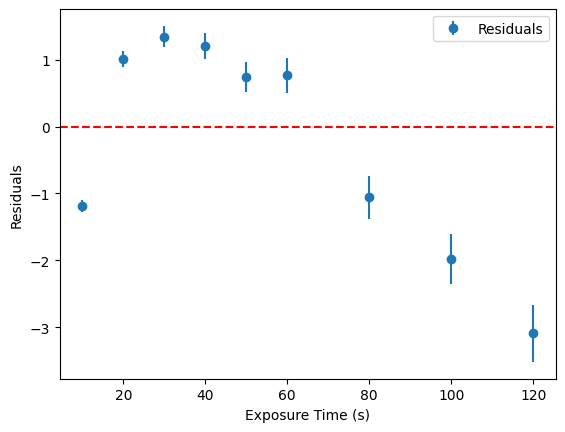

Calculated mean of the bias frames: 1003.60
averaged dark frame mean [1089.87830639 1008.69760799 1106.98442459 1020.00199699 1029.44412804
 1038.41212845 1047.05791283 1056.19071388 1072.58418083]
Calculated mean of the bias frames: 1003.60
Estimated Dark Current: 1.6844585390547147 electrons/pixel/second
Standard Deviation of Dark Current: 0.11115527655193663 electrons/pixel/second


In [111]:
def main():
    file_list, exposure_times = create_file_list_2(folder_path)
    pixel_counts_array = load_dark_frames(file_list)
    
    if pixel_counts_array.size == 0:
        print("No files were successfully loaded. Please check file paths and file existence.")
        return

    means, uncertainties = calculate_statistics(pixel_counts_array)
    print( means, uncertainties) 
    # Perform linear regression
    (slope, intercept), (slope_err, intercept_err) = perform_linear_regression(exposure_times, means, uncertainties)

    # Plot results
    plot_mean_vs_exposure(exposure_times, means, uncertainties, slope, intercept)
    plot_residuals(exposure_times, means, uncertainties, slope, intercept)

    # Estimate dark current
    gain = 2.05
    avg_dark_current, std_dark_current = estimate_dark_current(means, exposure_times, gain)
    print(f"Estimated Dark Current: {avg_dark_current} electrons/pixel/second")
    print(f"Standard Deviation of Dark Current: {std_dark_current} electrons/pixel/second")

if __name__ == "__main__":
    main()

Main function carries out our calculations calling the defined functions with the appropriate parameters and values, consolidating the processes of calculation. Observed lower residuals the greater our exposure time, as expected as we know that increasing the exposure time generally gives us better results and data. We also observe the expected positvely linear relationship between mean counts of the dark current as well as exposure times. Higher exposure means an increase in Signal-to-ratio which would imply higher counts and therefore dark current.

## 4.3: Flat Frames (Trevor)

(A description of what's going on here. Flat fields are best taken day-of, since conditions vary by the day.)

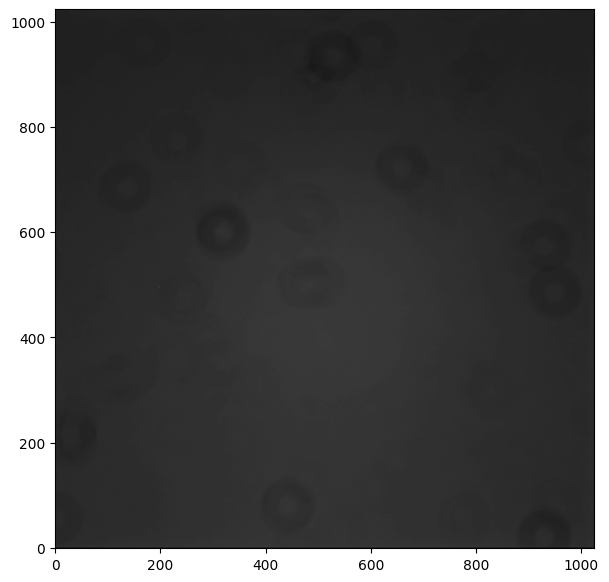

In [112]:
#get list of filepaths to use. Note the unfortunate machine dependence
imaging_flat_path_list = [r"Group 2 Data\Photometry\flats\flat_0.3s_exposure_.0000000" + 
                  str(j) + r".FLAT.FIT" for j in range(10)]

#make + save master flat
master_imaging_flat_array = median_combine(fits_data_to_3d_array(imaging_flat_path_list))
save_array_as_fits(master_imaging_flat_array,'master_imaging_flat.fits')

#For a preliminary viewing:
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(master_imaging_flat_array,origin='lower',cmap='gray')

The central bright spot's pixels see about 26200-26400 counts. The darkest large regions are top corners, which receive about 24400-24600 counts per pixel. An apparent superposition of dust rings in the upper middle shows only about 24000 counts per pixel.

In [113]:
mflat_ratio = 24500./26300.
mag_change = -2.5*np.log10(mflat_ratio)
print(f"A star's magnitude would change by about {mag_change:.2f} moving from the center to an upper corner.")

A star's magnitude would change by about 0.08 moving from the center to an upper corner.


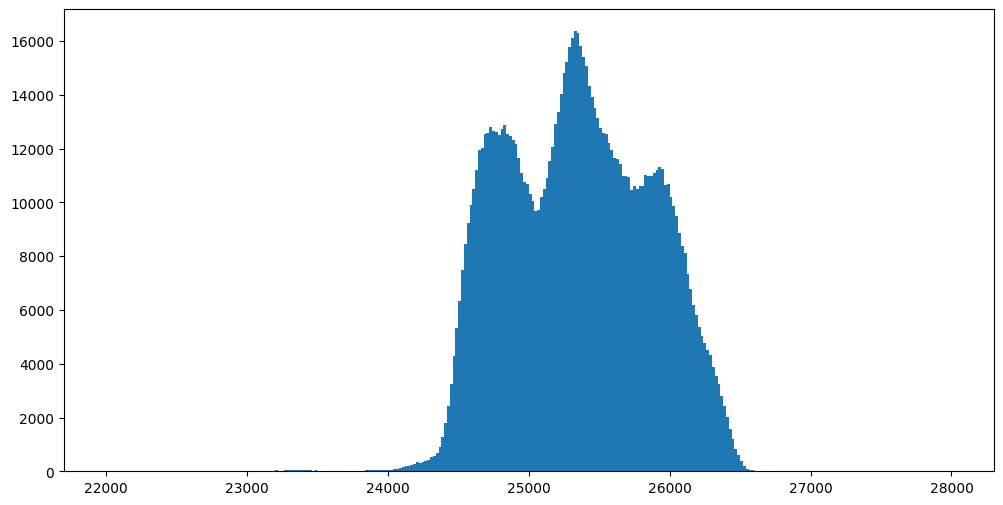

In [122]:
#scipy has a hard time getting a gaussian fit for this very non-gaussian data
#the lower peak may come from dust or vignetting, 
#the higher peak might come from particularly bright areas like the center?
fig, ax = plt.subplots(figsize=(12,6))
plot_hist = ax.hist(master_imaging_flat_array.flatten(),300,[22000,28000])

In [123]:
(master_imaging_flat_array < 18000).sum() #counts how many by adding Trues as 1s. The dead counting method can be revised to reveal their location.

np.int64(0)

## 4.4.1 - 4.4.4 (Anthony)

In [128]:
#Import FITS File Locations:
flats_file_list = create_file_list(r'Group 2 Data\Spectograph\Flats', 
          file_name = 'spectrograph_flats_20s_', frame_type = '.FLAT', num_of_files= 10, show_list=False)
spectrum_file_list = create_file_list(r'C:Group 2 Data\Spectograph\lights', 
          file_name = 'spectrograph_lights_20s_', frame_type = '', num_of_files= 10, show_list=False)

#Create FITS Image Data Arrays:
flat_field_array_3d = fits_data_to_3d_array(flats_file_list)
spectrum_array_3d = fits_data_to_3d_array(spectrum_file_list)

### 4.4.1: Determining Spectra Corresponding to $50 \mu m$ slit
The spectra corresponding to the $50 \mu m$ slit should have the highest signal-to-noise ratio in the flat frames. It should also have the lowest resolution when looking at the spectrum. 

The following segment of code displays the one of the flats here, but this can also be done with ds9.

In [129]:
flat_field_array = median_combine(flat_field_array_3d)
spectrum_array = median_combine(spectrum_array_3d)

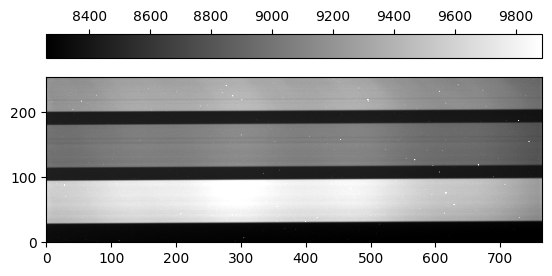

In [131]:
# Display Flat-Field
display_2d_array(flat_field_array)

As can be seen, the lower strip comes from the $50 \mu m$ slit. It has the highest signal to noise ratio. When viewing a the spectrum (seen below), you can also see that the lower strip has the lowest resolution spectral lines.

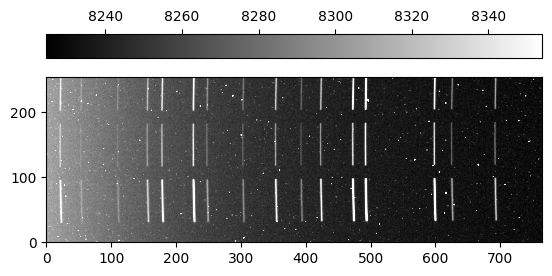

In [132]:
display_2d_array(spectrum_array)

### 4.4.2: Plot 1D Flat-Field Values vs Pixel Position (Along Dispersion Axis)
Steps we need to take: \
1)Cut the images to work with data only from the target $50 \mu m$ slit. \
2)Take the 2D array of the image data and find the median value of each column. This will create a 1D array with intensity values corresponding to pixel positions. \
3)Plot the 1D array vs pixel position.

(60, 765)


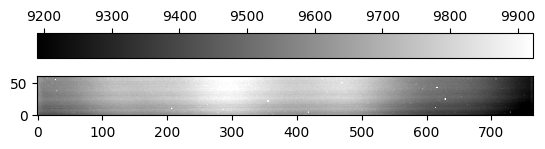

In [133]:
#Step 1

#Going into ds9, I decided to make a cut in the following range: 34 <= y <= 94
#These values correspond to the rows that will need to be cut from the flat field array.
flat_field_cut = cut_images_array(flat_field_array, y_pixel_min=34, y_pixel_max=94)
display_2d_array(flat_field_cut)

#np.savetxt("flat_frame_0.csv", flat_frame_0, delimiter = ",", fmt='%d')
#np.savetxt("flat_frame_0_cut.csv", flat_frame_0_cut, delimiter = ",", fmt='%d')

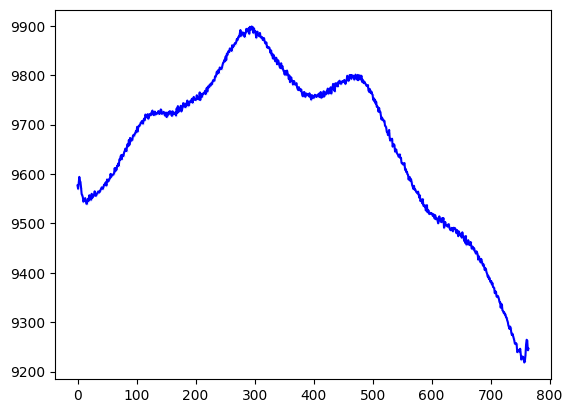

In [134]:
#Step 2
#Find the median of each column and turn into 1D array
flat_field_median = np.median(flat_field_cut, axis=0)
indices = np.arange(len(flat_field_median)) #Create 1d array of indices

#Step 3
#Plot median values vs position
plt.plot(indices, flat_field_median, marker='.', ms=0.1, linestyle='solid', color='blue')

### 4.4.3: Normalize The Flat Field

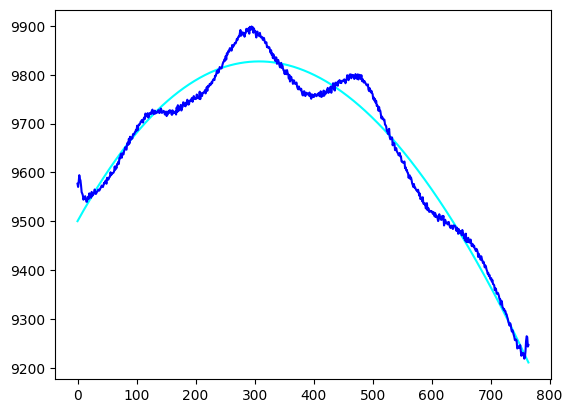

In [135]:
#Fit A Polynomial To The 1D Flat-Field Array Data
degree = 3
coefficients = np.polyfit(indices, flat_field_median, degree)

polynomial_fit = np.polyval(coefficients, indices)
polynomial_fit_2d = np.tile(polynomial_fit, (flat_field_cut.shape[0], 1))
normalized_flat_field = flat_field_cut / polynomial_fit_2d

plt.plot(indices, polynomial_fit, color='cyan')
plt.plot(indices, flat_field_median, color='blue')

np.savetxt("normalized_flat_field.csv", normalized_flat_field, delimiter = ",", fmt='%d')

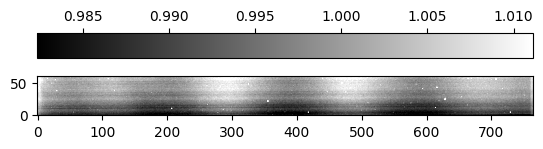

In [136]:
display_2d_array(normalized_flat_field)

### 4.4.4: Normalize The Arc Lamp Spectrum

(60, 765)


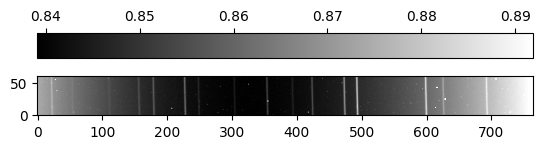

In [137]:
spectrum_array_cut = cut_images_array(spectrum_array, y_pixel_min=34, y_pixel_max=94)
spectrum_normalized = spectrum_array_cut / polynomial_fit_2d
display_2d_array(spectrum_normalized)

In [138]:
#Normalized Flat-Field to Fit
data_array = normalized_flat_field
hdu = fits.PrimaryHDU(data_array)
hdul = fits.HDUList([hdu])
#hdul.writeto('normalized_flat_field_-dark.fit', overwrite=True)
#Normalized Spectrum to Fit
data_array = spectrum_normalized
hdu = fits.PrimaryHDU(data_array)
hdul = fits.HDUList([hdu])
#hdul.writeto('normalized_spectrum_-dark.fit', overwrite=True)

## 4.5

Bias frames must be subtracted from flats and possibly darks and raw data.

Dark frames must be subtracted from raw data. This subtraction may also subtract bias frames, if they were not subtracted from the darks already.

Flat frames represent the effective sensitivity of the pixels, and must be divided after bias is subtracted.

Ideally, all calibration is done on the same day as the data. If the camera can control its temperature largely independent of local conditions, Bias and Dark frames become largely condition-independent, unless more pixels become hot since the camera was last used, so typically they can be taken later. Flat frames are more strongly dependent on current conditions, since they involve images of the world outside the camera. 